In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
%matplotlib inline

In [3]:
train_data=pd.read_csv(r'C:\Users\anike\jupyter_code\Semester 5 DL Project\tweet-sentiment-extraction\train.csv',header=0)
test_data=pd.read_csv(r'C:\Users\anike\jupyter_code\Semester 5 DL Project\tweet-sentiment-extraction\test.csv',header=0)

In [4]:
data=pd.concat([train_data[['text','sentiment']],test_data[['text','sentiment']]],axis=0)
data.dropna()
data['text']=data['text'].astype(str)
data.describe()

,text,sentiment
count,31015,31015
unique,31015,3
top,"I`d have responded, if I were going",neutral
freq,1,12548


In [5]:
'''
EXPLORATORY DATA ANALYSIS : 
- Checking class distribution
- Text length distribution
- WordCloud
'''
def eda(df):
    # CLASS DISTRIBUTION
    print("Class Distribution :\n")
    print(df['sentiment'].value_counts())
    print("\n\n")
    sns.countplot(x='sentiment',data=df)
    plt.title("Class Distribution")
    plt.show()
    print("\n\n")
    
    # TEXT LENGTH DISTRIBUTION
    df['text_length'] = df['text'].apply(lambda x: len(x.split()))
    sns.histplot(df['text_length'], bins=50, kde=True)
    plt.title("Text Length Distribution")
    plt.show()
    print("\n\n")
    
    # CLASSWISE WORDCLOUD
    color_palettes=['magma','viridis','inferno']
    color_idx=0
    for x in df['sentiment'].unique():
        subset=df[df['sentiment']==x]
        text=" ".join(subset['text'])
        wordcloud = WordCloud(width=800, height=400, background_color='white',colormap=color_palettes[color_idx]).generate(text)
        color_idx+=1
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Wordcloud for {x} class",fontsize=25,fontweight='bold')
        plt.axis("off") #hides axis lines from wordcloud
        plt.show()
        print()

In [11]:
'''
preprocessing text or cleaning text
- lowercasing
- replacement of URL's and numbers with placeholders
- handling of punctuation
'''
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'(?i)http\S+|www\S+|https\S+', '<URL>', text, flags=re.IGNORECASE|re.MULTILINE)
    text = re.sub(r'\d+', '<NUM>', text)
    text = re.sub(r'!', ' <EXCLAMATION> ', text)
    text = re.sub(r'\?', ' <QUESTION> ', text)
    text = re.sub(r'\.\.\.', ' <ELLIPSIS> ', text)
    text = re.sub(r'[^\w\s<EXCLAMATION><QUESTION><ELLIPSIS><URL><NUM>]', '', text) # removes punctuation and special characters except the mentioned placeholders
    return text

In [13]:
'''
Preprocesses the dataset for model input:
    - Applies `preprocess_text` to data and creates clean data
    - Encodes target labels
    - Tokenizes and pads text sequences
'''
def preprocess_data(df,num_words,maxlen):
    # TEXT PREPROCESSING
    df['clean_text']=df['text'].apply(preprocess_text)
    # LABEL ENCODING OF SENTIMENT CLASSES
    labelencoder=LabelEncoder()
    df['encoded_class']=labelencoder.fit_transform(df['sentiment'])
    # TOKENIZING TEXT & GETTING SEQUENCES
    tokenizer=Tokenizer(num_words=num_words,oov_token="<OOV>")
    tokenizer.fit_on_texts(df['clean_text'])
    sequences=tokenizer.texts_to_sequences(df['clean_text'])
    # PADDING SEQUENCES
    padded_sequences=pad_sequences(sequences,maxlen=maxlen,padding='post',truncating='post')
    return padded_sequences,df['encoded_class'],tokenizer


In [31]:
# '''
# Model functions with tunable parameters.
# We are going to be using two models: 
# - LSTM
# - CNN
# '''

# # LSTM
# def tunable_lstm(embedding_dim=128,units=64,dropout=0.2,optimizer='adam'):
#     model = Sequential([
#         Embedding(input_dim=17000, output_dim=embedding_dim, input_length=100),
#         LSTM(units, return_sequences=False),
#         Dropout(rate=dropout),
#         Dense(3, activation='softmax')
#     ])
#     model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model


# # CNN
# def tunable_cnn(embedding_dim=128, filters=64, kernel_size=3, dropout=0.2, optimizer='adam'):
#     model = Sequential([
#     Embedding(input_dim=17000, output_dim=embedding_dim, input_length=100),
#     Conv1D(filters, kernel_size, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dropout(rate=dropout),
#     Dense(3, activation='softmax')])
#     model.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

In [16]:
# LSTM
def tunable_lstm(embedding_dim=128,units=64,dropout=0.2,optimizer='adam'):
    model = Sequential([
        Embedding(input_dim=17000, output_dim=embedding_dim, input_length=100),
        LSTM(units, return_sequences=False),
        Dropout(rate=dropout),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
# # HYPERPARAMETER TUNING FUNCTION using GRID SEARCH CV
# def hyperparameter_tuning_lstm(param_grid,x_train,y_train):
#     model_lstm=KerasClassifier(
#         build_fn=tunable_lstm,
#         epochs=10,
#         verbose=0
#     )
#     model_lstm.set_params(model__embedding_dim=128,model__units=64,model__dropout=0.2,model__optimizer='adam', fit__batch_size=64, fit__epochs=10)
    
#     grid_lstm=GridSearchCV(
#         estimator=model_lstm,
#         param_grid=param_grid,
#         cv=3,
#         n_jobs=-1,
#         verbose=1,
#         error_score='raise'
#     )
#     result=grid_lstm.fit(x_train,y_train)
#     print(f"\nBest Parameters for lstm: {result.best_params_}")
#     print(f"\nBest Cross-Validation Accuracy for lstm: {result.best_score_}")
#     return result.best_estimator_.model

In [19]:
# def hyperparameter_tuning_cnn(param_grid,x_train,y_train):
#     model_cnn=KerasClassifier(build_fn=tunable_cnn,epochs=10,verbose=0)
#     model_cnn.set_params(model__embedding_dim=128,model__filters=64, model__kernel_size=3, model__dropout=0.2,model__optimizer='adam', fit__batch_size=64, fit__epochs=10)
#     grid_cnn=GridSearchCV(estimator=model_cnn,param_grid=param_grid,cv=3,n_jobs=-1,verbose=1,error_score='raise')
#     result=grid_cnn.fit(x_train,y_train)
#     print(f"\nBest Parameters: {result.best_params_}")
#     print(f"\nBest Cross-Validation Accuracy: {result.best_score_}")
#     return result.best_estimator_.model

In [21]:
# STARTING MAIN CODE

Class Distribution :

sentiment
neutral     12548
positive     9685
negative     8782
Name: count, dtype: int64





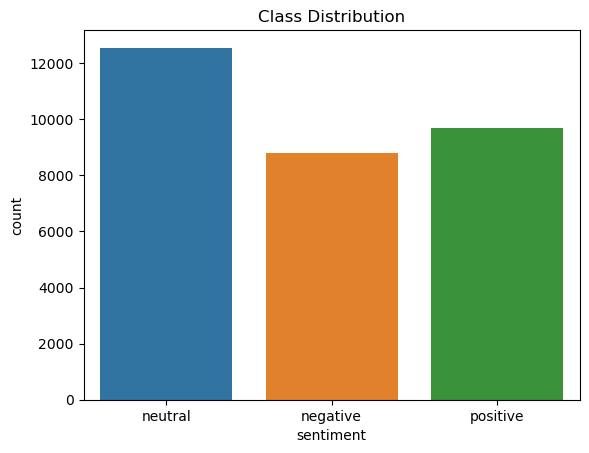

C:\Users\anike\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


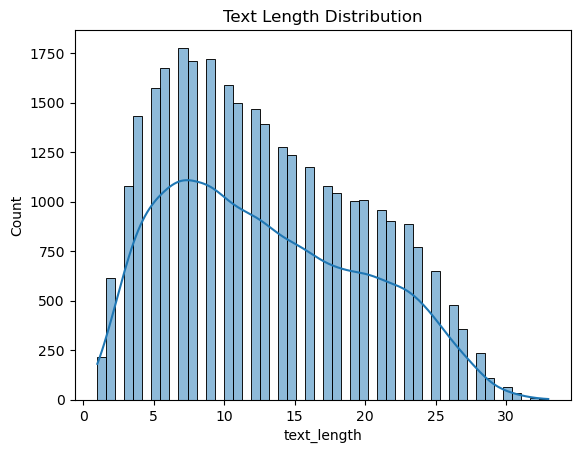

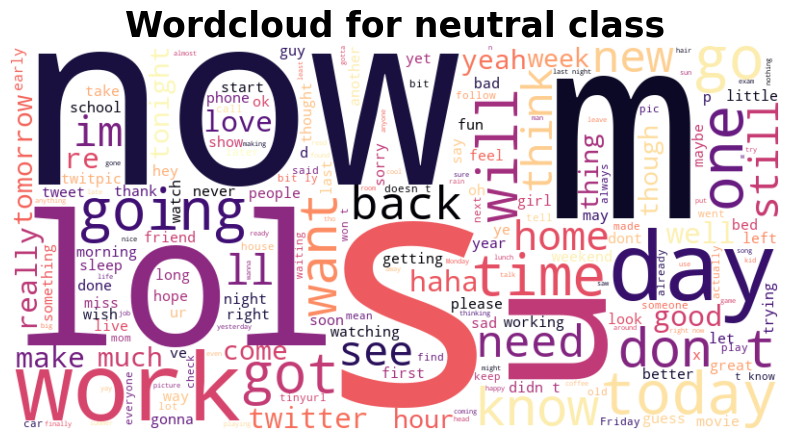

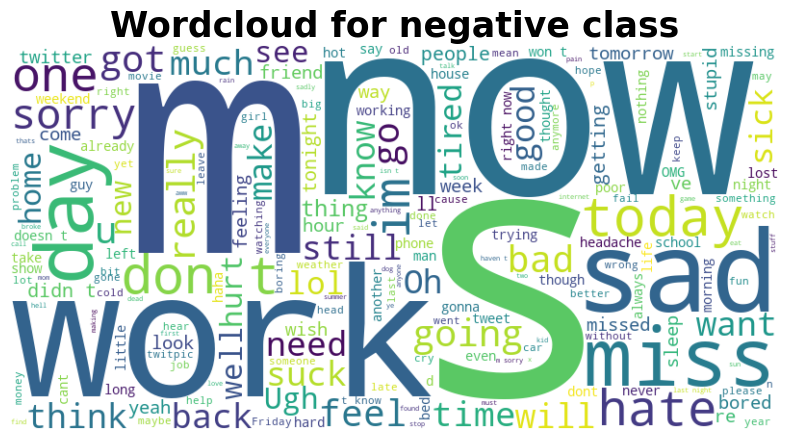

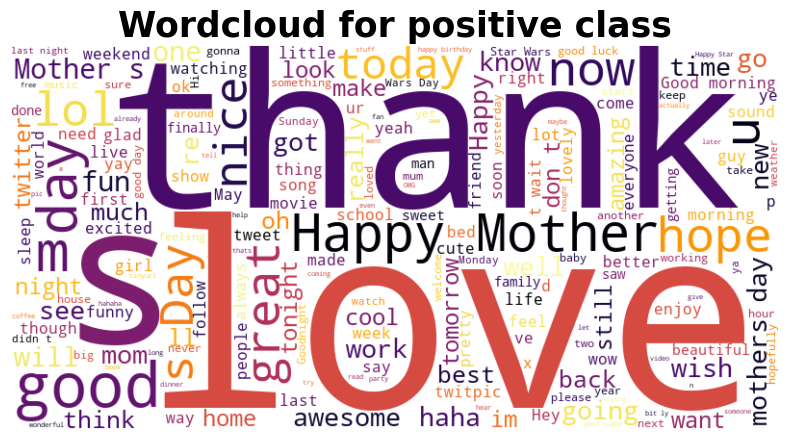

In [18]:
eda(data)

In [20]:
# HYPERPARAMETERS FOR TOKENIZATION
num_words_grid = [17000]
maxlen_grid = [50, 100, 150]

In [22]:
#INITIALIZING BEST  TOKENIZATION CONFIGURATION VARIABLES
best_num_words, best_maxlen = 17000, 100
best_accuracy = 0

In [24]:
# HYPERPARAMETER TUNING FOR TOKENIZATION USING 2 FOR LOOPS
for x in num_words_grid:
    for y in maxlen_grid:
        padded_sequences,labels,tokenizer=preprocess_data(data,num_words=x,maxlen=y)
        x_train,x_test,y_train,y_test=train_test_split(padded_sequences,labels,test_size=0.2,random_state=33)
        base_model=tunable_lstm()
        base_model.fit(x_train,y_train,epochs=2,batch_size=32,verbose=0)
        y_pred=np.argmax(base_model.predict(x_test),axis=-1)
        accuracy=accuracy_score(y_test,y_pred)
        if accuracy>best_accuracy:
            best_num_words,best_maxlen=x,y
            best_accuracy=accuracy
print(f"\nBest Tokenization configuration : num_words={best_num_words}, maxlen={best_maxlen}")

C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

Best Tokenization configuration : num_words=17000, maxlen=50


In [25]:
# Preprocessing Data with Best Parameters
padded_sequences, labels, tokenizer = preprocess_data(data, num_words=best_num_words, maxlen=best_maxlen)
x_train,x_test,y_train,y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=33)

In [63]:
# # Hyperparameter grids for both models
# lstm_param_grid = {
#     'model__embedding_dim': [128, 256],
#     'model__units': [64, 128, 256],
#     'model__dropout': [0.1, 0.2, 0.3],
#     'model__optimizer': ['adam','rmsprop'],

#     # fit/training parameters
#     'fit__batch_size': [32, 64, 128],
#     'fit__epochs': [10, 15]
# }

# cnn_param_grid = {
#     'model__embedding_dim': [128, 256],
#     'model__filters': [32, 64, 128],
#     'model__kernel_size': [3, 5, 7],
#     'model__dropout': [0.1, 0.2, 0.3],
#     'model__optimizer': ['adam','rmsprop'],

#     # fit/training parameters
#     'fit__batch_size': [32, 64, 128],
#     'fit__epochs': [10, 15]
# }

In [89]:
# # Hyperparameter tuning for LSTM
# print("\nTuning LSTM Model...")
# best_lstm_model = hyperparameter_tuning_lstm(lstm_param_grid, x_train, y_train)

In [26]:
# LSTM MODEL
model_lstm = Sequential([
    Embedding(input_dim=17000, output_dim=128, input_length=50),
    LSTM(units=64, return_sequences=False),
    Dropout(rate=0.2),
    Dense(3, activation='softmax')
])
model_lstm.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
# LSTM MODEL TRAINING and VALIDATION
earlystopping=EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
model_lstm.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=6,batch_size=32)

Epoch 1/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.3993 - loss: 1.0893 - val_accuracy: 0.4061 - val_loss: 1.0866
Epoch 2/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.4059 - loss: 1.0856 - val_accuracy: 0.5399 - val_loss: 0.9423
Epoch 3/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.5640 - loss: 0.8811 - val_accuracy: 0.6247 - val_loss: 0.8089
Epoch 4/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6675 - loss: 0.7244 - val_accuracy: 0.6884 - val_loss: 0.7234
Epoch 5/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7534 - loss: 0.6068 - val_accuracy: 0.7010 - val_loss: 0.7193
Epoch 6/6
776/776 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8006 - loss: 0.5323 - val_accuracy: 0.6968 - val_loss: 0.7357


In [132]:
# for od in [32,64,128]:
#     for il in [50,100]:
#         for units in [32,64]:
#             for d in [0.1,0.2,0.5]:
#                 model_lstm = Sequential([
#                     Embedding(input_dim=17000, output_dim=od, input_length=il),
#                     LSTM(units=units, return_sequences=False),
#                     Dropout(rate=d),
#                     Dense(3, activation='softmax')
#                 ])
#                 model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#                 earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
#                 history=model_lstm.fit(x=x_train,y=y_train,validation_data=(x_test,y_test),epochs=10,batch_size=32)

#                 val_acc = history.history['val_accuracy'][-1]
#                 if val_acc > best_val_acc:
#                     best_config = {
#                                     'Batch Size': bsize,
#                                     'dense': dense,
#                                     'Optimizer': optimizer,
#                                     'd1': d1,
#                                     'ks':ks,
#                                     'filters':filters,
#                                     'outputdimension':od,
#                                     'Validation Accuracy': val_acc
#                                 }
#                     best_val_acc = val_acc
#                     for x in best_config:
#                         print(best_config[x])

Epoch 1/10


C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


776/776 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.4013 - loss: 1.0888 - val_accuracy: 0.4058 - val_loss: 1.0861
Epoch 2/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4033 - loss: 1.0882 - val_accuracy: 0.4059 - val_loss: 1.0868
Epoch 3/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4391 - loss: 1.0637 - val_accuracy: 0.5222 - val_loss: 0.9850
Epoch 4/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4949 - loss: 1.0057 - val_accuracy: 0.4880 - val_loss: 1.0075
Epoch 5/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4769 - loss: 1.0164 - val_accuracy: 0.4711 - val_loss: 1.0156
Epoch 6/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4694 - loss: 1.0182 - val_accuracy: 0.4823 - val_loss: 1.0106
Epoch 7/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4788 - loss: 1.0105 - val_accuracy: 0.4885 - val_loss: 1.0059
Epoch 8/10
776/776 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.4464 - loss: 1.0542 - val_accuracy: 0.4277 - val_

In [39]:
# for x in best_config:
#     print(best_config[x])

In [32]:
# CNN Model
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=17000, output_dim=128, input_length=50))
model_cnn.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dropout(0.6))
model_cnn.add(Dense(3, activation='softmax'))
                            
model_cnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model_cnn.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],epochs=8,batch_size=128,callbacks=[earlystopping])


Epoch 1/8


C:\Users\anike\anaconda\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


194/194 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4046 - loss: 1.0818 - val_accuracy: 0.6131 - val_loss: 0.9324
Epoch 2/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5706 - loss: 0.9040 - val_accuracy: 0.7061 - val_loss: 0.7297
Epoch 3/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6914 - loss: 0.7584 - val_accuracy: 0.7269 - val_loss: 0.6723
Epoch 4/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7317 - loss: 0.6794 - val_accuracy: 0.7377 - val_loss: 0.6528
Epoch 5/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7535 - loss: 0.6308 - val_accuracy: 0.7356 - val_loss: 0.6460
Epoch 6/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7689 - loss: 0.5875 - val_accuracy: 0.7348 - val_loss: 0.6441
Epoch 7/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7929 - loss: 0.5420 - val_accuracy: 0.7369 - val_loss: 0.6486
Epoch 8/8
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8055 - loss: 0.4979 - val_accuracy: 0.7284 - val

In [47]:
# # HYPERPARAMETER TUNING FOR CNN
# results={}
# best_config = None
# best_val_acc = 0
# for od in [64,128]:
#     for filters in [32,64,128]:
#         for dense in [16,32,64]:
#             for bsize in [32,128]:
#                             model_cnn = Sequential()
        
#                                 # Embedding layer
#                             model_cnn.add(Embedding(input_dim=17000, output_dim=od, input_length=50))
                                
#                                 # Convolutional layer
#                             model_cnn.add(Conv1D(filters=filters, kernel_size=5, activation='relu'))
                                
#                                 # GlobalMaxPooling layer
#                             model_cnn.add(GlobalMaxPooling1D())
                                
#                                 # Dropout for regularization
#                             model_cnn.add(Dropout(0.2))
                                
#                                 # Dense hidden layer
#                             model_cnn.add(Dense(dense, activation='relu'))
                                
#                                 # Dropout for additional regularization
#                             model_cnn.add(Dropout(0.6))
                                
#                                 # Output layer with softmax activation for multiclass classification
#                             model_cnn.add(Dense(3, activation='softmax'))
                            
#                             model_cnn.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#                             earlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
#                             history=model_cnn.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],epochs=10,batch_size=bsize,callbacks=[earlystopping])

#                             val_acc = history.history['val_accuracy'][-1]
#                             if val_acc > best_val_acc:
#                                 best_config = {
#                                     'Batch Size': bsize,
#                                     'dense': dense,
#                                     'Optimizer': optimizer,
#                                     'd1': d1,
#                                     'ks':ks,
#                                     'filters':filters,
#                                     'outputdimension':od,
#                                     'Validation Accuracy': val_acc
#                                 }
#                                 best_val_acc = val_acc
#                                 for x in best_config:
#                                     print(best_config[x])
                                

# print("Best Configuration:")
# for key, value in best_config.items():
#     print(f"{key}: {value}")